## Importando bibliotecas

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from geopy.geocoders import Nominatim
from time import sleep
import geopandas as gpd
from sklearn.model_selection import train_test_split

## Visualizando dados

In [2]:
df = pd.read_csv('rental_dataset')

In [3]:
display(df.describe())
display(df.info())
display(df.head())
display(df.shape)

,rental,rental_type,m2,nbeds,nrests,parking_space,address
count,9144,9144,9144,9144,9144,9144,9144
unique,940,3,683,15,28,42,2814
top,R$ 3.500,/Mês,75,--,1,1,"Centro, Florianópolis - SC"
freq,201,8352,195,3629,3168,2870,656


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9144 entries, 0 to 9143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rental         9144 non-null   object
 1   rental_type    9144 non-null   object
 2   m2             9144 non-null   object
 3   nbeds          9144 non-null   object
 4   nrests         9144 non-null   object
 5   parking_space  9144 non-null   object
 6   address        9144 non-null   object
dtypes: object(7)
memory usage: 500.2+ KB


None

,rental,rental_type,m2,nbeds,nrests,parking_space,address
0,R$ 5.500,/Mês,150,3,2,1,"Rodovia Tertuliano Brito Xavier - Jurerê, Flor..."
1,R$ 1.850,/Mês,70,2,2,2,"Rua Professor Clementino de Brito, 77 - Capoei..."
2,R$ 6.600,/Mês,300,4,5,4,"Santinho, Florianópolis - SC"
3,R$ 1.200,/Mês,43,--,1,1,"Rua Campolino Alves, 84 - Capoeiras, Florianóp..."
4,R$ 2.200,/Mês,60,2,2,1,"Rua João Meirelles, 884 - Abraão, Florianópoli..."


(9144, 7)

## DataCleaning e DataEngineering 

In [4]:
df['rental_type'].value_counts()

rental_type
/Mês    8352
/Dia     789
/Ano       3
Name: count, dtype: int64

In [5]:
## Alguns dos alugueis estão em dias e outros em ano, então vamos começar retirando as residências que tem aluguel nesse tipo
df_filtered = df.loc[df['rental_type'] == '/Mês']
display(df_filtered.shape)

(8352, 7)

In [6]:
## Alguns alugueis podem estar duplicados, vamos retira-los também
df_filtered = df_filtered.drop_duplicates()
display(df_filtered.shape)

(7004, 7)

In [7]:
## Como vimos ja na base de dados, temos alguns dados faltantes e varios dos registros, vamos retirar todos eles
df_filtered = df_filtered.query('rental != "--" & m2 != "--" & nbeds != "--" & nrests != "--" & parking_space != "--"')

In [8]:
## Vamos retirar também a coluna rental_type, que não será relevante visto que todos são do mesmo tipo
df_filtrered = df_filtered.drop(columns='rental_type')

In [9]:
## Reorganizando os indices
df_filtrered = df_filtrered.reset_index()

In [10]:
## agora precisamos retirar o simbolo de moeda do rental, além de trocar os tipos das colunas que estão como objeto, 
## exceto o address

## Retirando cifrão e transformando em float
df_filtrered['rental'] = df_filtrered['rental'].apply(lambda x: x[3:])
df_filtrered['rental'] = df_filtrered['rental'].astype('float')

## Modificando tipo das colunas
for column in ['m2', 'nbeds', 'nrests', 'parking_space']:
    df_filtrered[column] = df_filtrered[column].astype('int')


In [11]:
## Todas as colunas foram tratas e retiramos os erros
df_filtrered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3686 entries, 0 to 3685
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          3686 non-null   int64  
 1   rental         3686 non-null   float64
 2   m2             3686 non-null   int32  
 3   nbeds          3686 non-null   int32  
 4   nrests         3686 non-null   int32  
 5   parking_space  3686 non-null   int32  
 6   address        3686 non-null   object 
dtypes: float64(1), int32(4), int64(1), object(1)
memory usage: 144.1+ KB


In [12]:
## Antes de partir para a próxima etapa precisamos retirar algunas informações do address para ajudar na analise exploratória
## Além disso vamos transformar o endereço em coordenadas geográficas, isso irá facilitar muito ao criar o modelo

def address_transform(address):
    ## Divide a string do endereço em 4
    pattern = r'(.+), .* - .*'
    string = address
    result = re.match(pattern, string)
    street_district = result.groups()[0]
    ## Pegar o bairro
    pattern2 = r'\b\w+\b'
    district = re.findall(pattern2, street_district)
    return district[-1]

## Primeiro vamos criar as colunas
df_filtrered['district'] = ''

## Agora vamos adicionar informações a estar colunas
for idx in range(df_filtrered.shape[0]):
    list_address = address_transform(df_filtrered['address'][idx])
    df_filtrered.loc[idx, 'district'] = list_address

In [13]:
## Vamos dar uma olhada novamente nos dados
df_filtrered.head()

,index,rental,m2,nbeds,nrests,parking_space,address,district
0,0,5.50,150,3,2,1,"Rodovia Tertuliano Brito Xavier - Jurerê, Flor...",Jurerê
1,1,1.85,70,2,2,2,"Rua Professor Clementino de Brito, 77 - Capoei...",Capoeiras
2,2,6.60,300,4,5,4,"Santinho, Florianópolis - SC",Santinho
3,4,2.20,60,2,2,1,"Rua João Meirelles, 884 - Abraão, Florianópoli...",Abraão
4,5,5.50,130,3,2,1,"Rua dos Polvos, 581 - Jurerê, Florianópolis - SC",Jurerê


In [14]:
## Agora vamos transformar o addres em coordenadas geográficas
def address_locator(adress):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(adress, timeout=1)
    try:
        return location.latitude, location.longitude
    except:
        return .0, .0

In [15]:
## Criandos as colunas de latitude e longitude, bem como adicionando os valores a elas
df_filtrered['latitude'] = .0
df_filtrered['longitude'] = .0
for idx in range(len(df_filtrered)):
    latitude, longitude = address_locator(df_filtrered.loc[idx, 'address'])
    df_filtrered.loc[idx, 'latitude'] = latitude
    df_filtrered.loc[idx, 'longitude'] = longitude

In [22]:
## Agora vamos salvar nosso dataset limpo
df_filtrered_pro = df_filtrered.query('latitude != .0 | longitude != .0')
df_filtrered_pro = df_filtrered_pro.drop(columns=['index', 'address'])
df_filtrered_pro.to_csv('dataset_processed', index=False)

In [2]:
## Vamos dar uma olhadinha em como ficou nossos dados
df_processed = pd.read_csv('dataset_processed')
df_processed['rental'] = df_processed['rental']*1000
display(df_processed.shape)
df_processed.head(10)

(3426, 8)

,rental,m2,nbeds,nrests,parking_space,district,latitude,longitude
0,5500.0,150,3,2,1,Jurerê,-27.439839,-48.483585
1,1850.0,70,2,2,2,Capoeiras,-27.597232,-48.580665
2,6600.0,300,4,5,4,Santinho,-27.453741,-48.379112
3,2200.0,60,2,2,1,Abraão,-27.608853,-48.593756
4,5500.0,130,3,2,1,Jurerê,-27.442395,-48.488643
5,2300.0,112,3,2,1,Vermelho,-27.456289,-48.399505
6,3500.0,71,3,2,2,Canasvieiras,-27.434525,-48.458335
7,2650.0,69,2,2,1,Carvoeira,-27.603566,-48.528099
8,2800.0,108,2,2,1,Vermelho,-27.435463,-48.407233
9,1700.0,55,2,2,1,Vermelho,-27.439907,-48.401143


## Analise Exploratórioa de dados

In [3]:
df_processed = pd.read_csv('dataset_processed')
df_processed['rental'] = df_processed['rental']*1000
display(df_processed.shape)
df_processed.head(10)

(3426, 8)

,rental,m2,nbeds,nrests,parking_space,district,latitude,longitude
0,5500.0,150,3,2,1,Jurerê,-27.439839,-48.483585
1,1850.0,70,2,2,2,Capoeiras,-27.597232,-48.580665
2,6600.0,300,4,5,4,Santinho,-27.453741,-48.379112
3,2200.0,60,2,2,1,Abraão,-27.608853,-48.593756
4,5500.0,130,3,2,1,Jurerê,-27.442395,-48.488643
5,2300.0,112,3,2,1,Vermelho,-27.456289,-48.399505
6,3500.0,71,3,2,2,Canasvieiras,-27.434525,-48.458335
7,2650.0,69,2,2,1,Carvoeira,-27.603566,-48.528099
8,2800.0,108,2,2,1,Vermelho,-27.435463,-48.407233
9,1700.0,55,2,2,1,Vermelho,-27.439907,-48.401143


In [87]:
## Vamos começar pelo preço médio dos alugueis por district
groupby_district_mean = df_processed.groupby(['district'])['rental'].mean()
groupby_district_mean

district
Abraão            4243.076923
Abrigo           10200.000000
Agronômica       10377.037500
Atlântico         6733.744186
Açores           10666.666667
Balneário         6889.393939
Base              3850.000000
Brava             2657.142857
Cacupé           23817.200000
Campeche          6603.545852
Canajure          8500.000000
Canas             3522.000000
Canasvieiras      4081.973684
Canto             3870.705882
Capoeiras         3303.340909
Carianos          3943.200000
Carvoeira         4736.421875
Centro            9556.207343
Coloninha         3955.714286
Conceição         9238.943089
Coqueiros         5494.545455
Daniela          20928.571429
Estreito         41040.144928
Grande            7085.523256
Ilha              3959.637931
Internacional    22815.227273
Itacorubi         4832.739884
Itaguaçu         12050.000000
Jesus            15016.819444
Jorge             5400.000000
Jurerê           11366.428571
Lagoa             6917.235294
Limões            3486.000000
L

In [4]:
## Vamos dar uma olhada nos valores maximos de alugueis
## Logo ao ver esses dados conseguivos ver claramente alguns alugueis que passam de 100000
## A maneira mais simples é retirando eles da conta
groupby_district_max = df_processed.groupby(['district'])['rental'].max()
## vamos pegar os 10 primeiros com maior valor
groupby_district_max.sort_values(ascending=False)
ten_max_rental = groupby_district_max.sort_values(ascending=False)[0:10].index.values

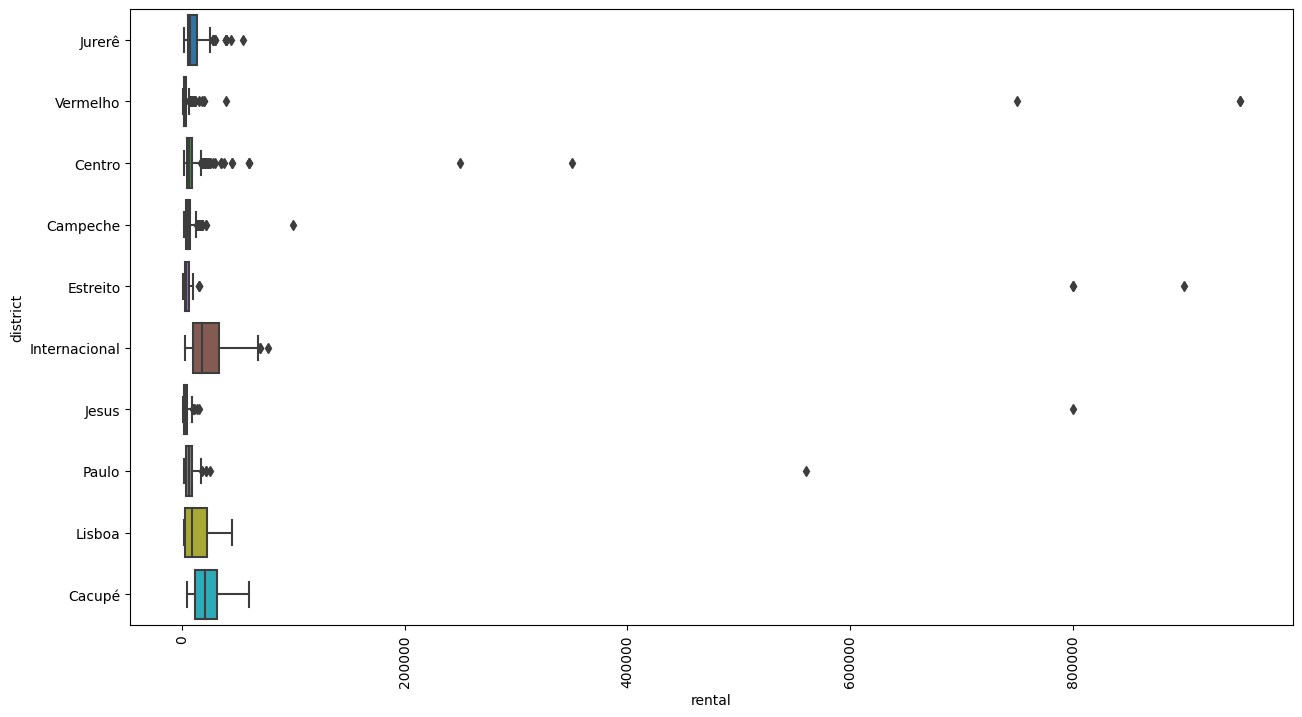

In [5]:
## Vamos plotar um boxplot
## claramente nesse plot conseguimos ver outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_processed.loc[df_processed['district'].isin(ten_max_rental)], y='district', x='rental')
plt.xticks(rotation=90);

<Axes: >

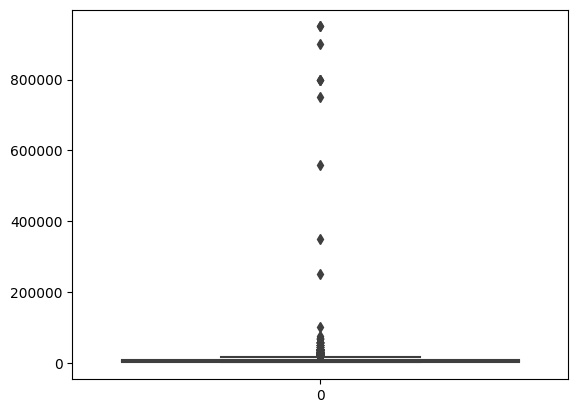

In [6]:
## Plotando um boxplot apenas dos alugueis, conseguimos ver como os dados são desbalanceados, isso irá impactar muito na criação
## do modelo preditivo, então vamos tratar esses outliers
sns.boxplot(df_processed['rental'])

In [19]:
## Aplicando algumas métricas do boxplot
Q2 = df_processed['rental'].median()
Q1 = df_processed.loc[df_processed['rental'] < Q2, 'rental'].median()
Q3 = df_processed.loc[df_processed['rental'] > Q2, 'rental'].median()
IQR = Q3 - Q1
SUPERIOR = Q3 + 1.5*IQR
INFERIOR = Q1 - 1.5*IQR
print('Limite superior: ' ,SUPERIOR, 'Limite inferior:', INFERIOR)
## Com esses dados em mãos vamos retirar os outliers da nossa base de dados

Limite superior:  17506.25 Limite inferior: -5443.75


In [35]:
## O limite inferior não foi usado na query, bem porque é negativo, e nem um dono de apartamento paga para você morar nele né kkkk
df_processed = df_processed.query('rental < 17506.25')

<Axes: >

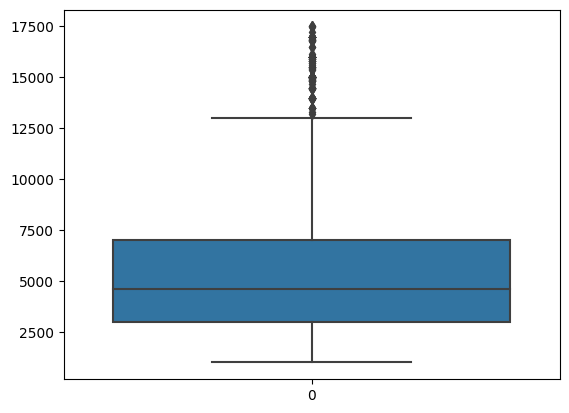

In [37]:
## Agora sim os dados estão bem melhores não acham?
## Bom, agora podemos continuar
sns.boxplot(df_processed['rental'])

In [100]:
## Valor máximo de alugueis
df_processed['rental'].max()

17500.0

In [39]:
## Quantos alugueis temos para cada district que vamos analisar?
df_processed[['district']].value_counts()

district     
Campeche         448
Centro           415
Vermelho         311
Itacorubi        173
Agronômica       134
Tavares          128
Jurerê           124
Conceição        105
Internacional    102
Trindade         100
Grande            76
Canasvieiras      75
Jesus             71
Paulo             69
Estreito          66
Coqueiros         66
Carvoeira         62
Ilha              58
Abraão            52
Capoeiras         44
Atlântico         36
Canto             34
Balneário         33
Lagoa             32
Carianos          25
Limões            25
Pantanal          22
Pedras            17
Cacupé            17
Lisboa            16
Santinho          16
Sul               12
Sambaqui          11
Jorge             11
Mar               11
Canas             10
Mônica            10
Verde              8
Coloninha          7
Brava              7
Itaguaçu           7
Daniela            4
Norte              3
Ratones            3
Ribeirão           3
Pirajubaé          2
Ribeirao           2

In [46]:
## Vamos agrupar por distrito para darmos uma olhada como esta os valores dos alugueis
rental_mean_groupby = df_processed.groupby(['district'])['rental'].mean()

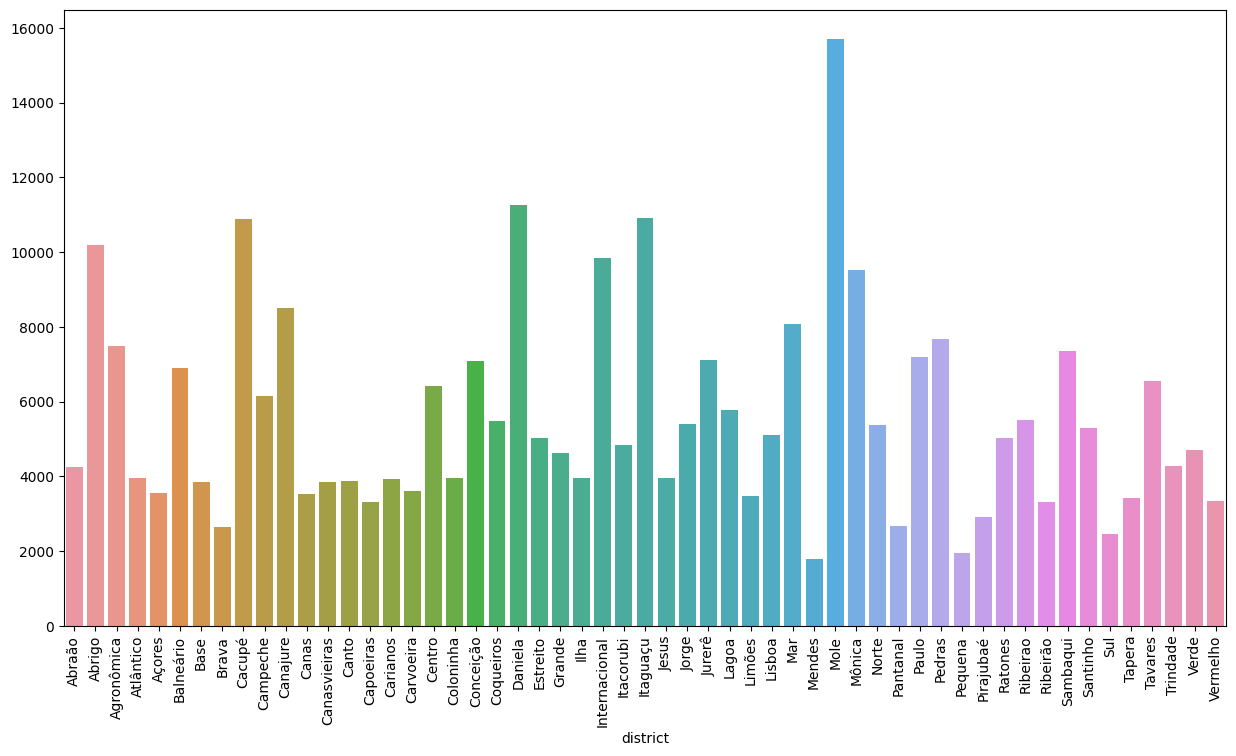

In [48]:
## Não é possivel dizer com certeza que os a média dos alugueis está correta para alguns distritos, visto que temos poucas
## amostras para algum deles, a melhor maneira de cuidar desses casos seria coletar mais dados para essas regiões, mas vamos
## prosseguir
plt.figure(figsize=(15, 8))
sns.barplot(y=rental_mean_groupby.values, x=rental_mean_groupby.index)
plt.xticks(rotation=90);

<Axes: xlabel='m2', ylabel='rental'>

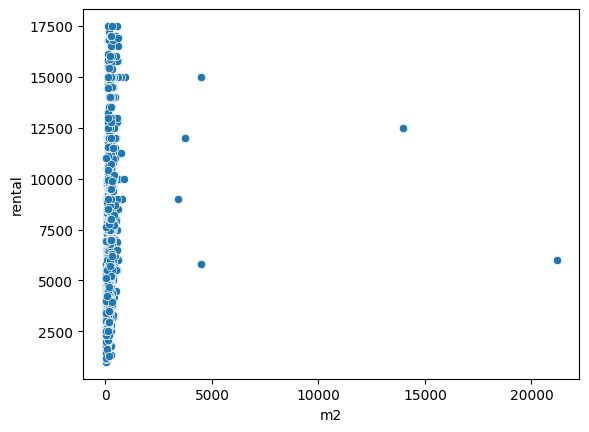

In [49]:
## Vamos ver o crescimento do preço com relação ao metro quadrado
## Aqui também conseguimos ver alguns dados estranhos, vamos dar uma olhada e fazer um boxplot deles
sns.scatterplot(x=df_processed['m2'], y=df_processed['rental'])

<Axes: >

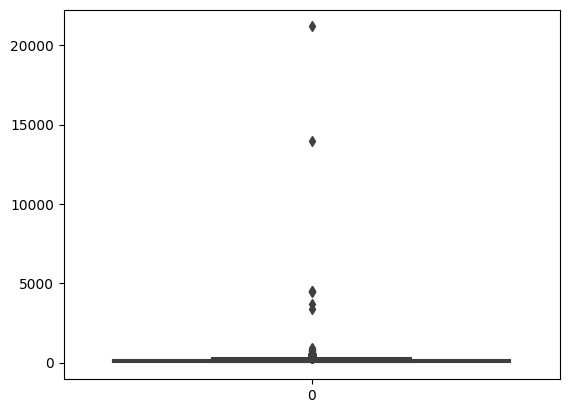

In [103]:
## Nossa como ta achatado isso aqui hein, vamos tratar esses outliers também
sns.boxplot(df_processed['m2'])

In [146]:
## Aplicando algumas métricas do boxplot
Q2 = df_processed['m2'].median()
Q1 = df_processed.loc[df_processed['m2'] < Q2, 'm2'].median()
Q3 = df_processed.loc[df_processed['m2'] > Q2, 'm2'].median()
IQR = Q3 - Q1
SUPERIOR = Q3 + 1.5*IQR
INFERIOR = Q1 - 1.5*IQR
## Agora com esses dados em vãos vamos retirar os outliers

In [122]:
df_processed = df_processed.query('m2 < 276')

<Axes: >

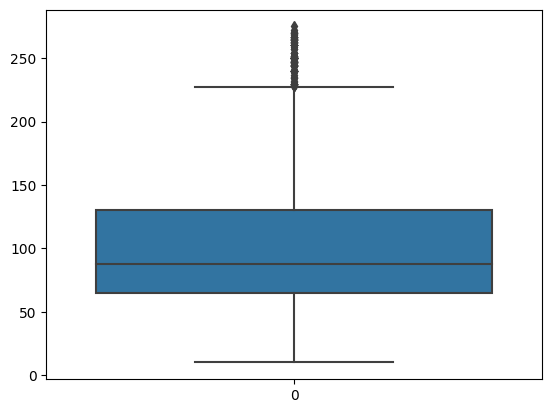

In [123]:
## Bem melhor agora
sns.boxplot(df_processed['m2'])

<Axes: xlabel='nbeds', ylabel='rental'>

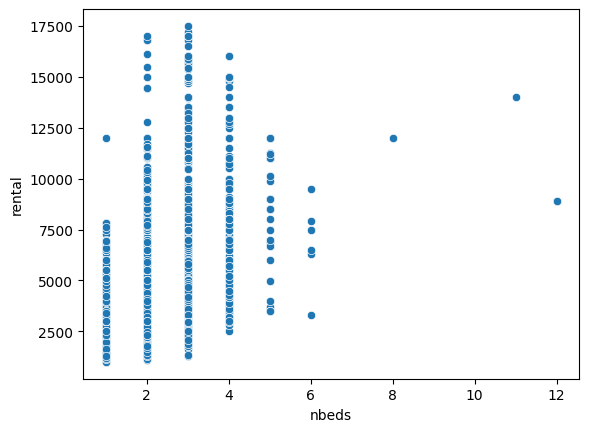

In [124]:
## Vamos ver o crescimento do preço com relação aos quartos
## Aqui vemos alguns casas com muitos quartos, bom é possivel, vamos manter os dados
sns.scatterplot(x=df_processed['nbeds'], y=df_processed['rental'])

<Axes: >

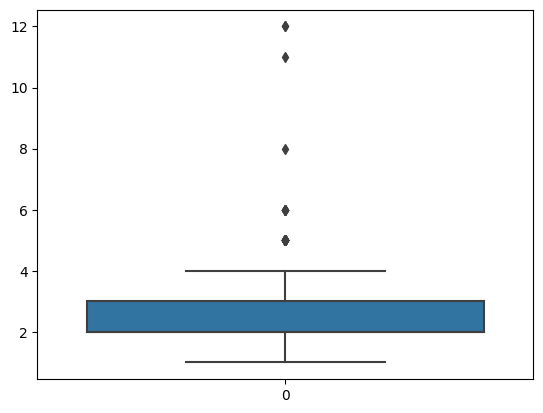

In [126]:
## Vamos manter os dados da maneira como estão para os quartos
sns.boxplot(df_processed['nbeds'])

<Axes: xlabel='nrests', ylabel='rental'>

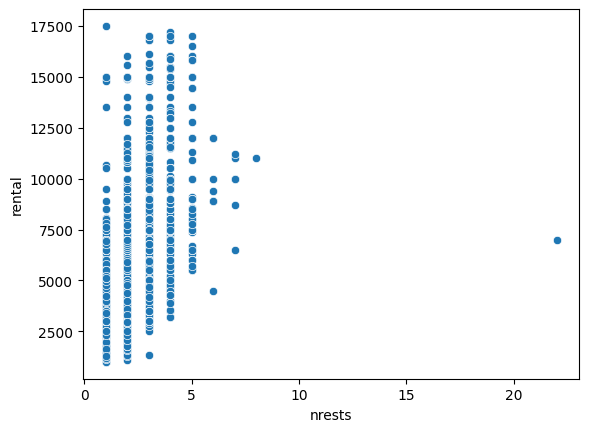

In [119]:
## Vamos ver o crescimento do preço com relação aos banheiros
sns.scatterplot(x=df_processed['nrests'], y=df_processed['rental'])

<Axes: >

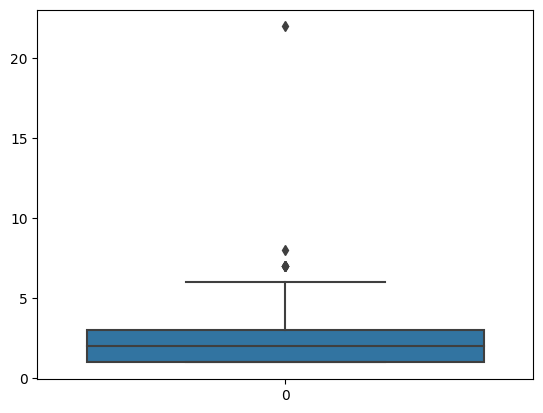

In [128]:
## Manteremos tambpem para o banheiros
sns.boxplot(df_processed['nrests'])

<Axes: xlabel='parking_space', ylabel='rental'>

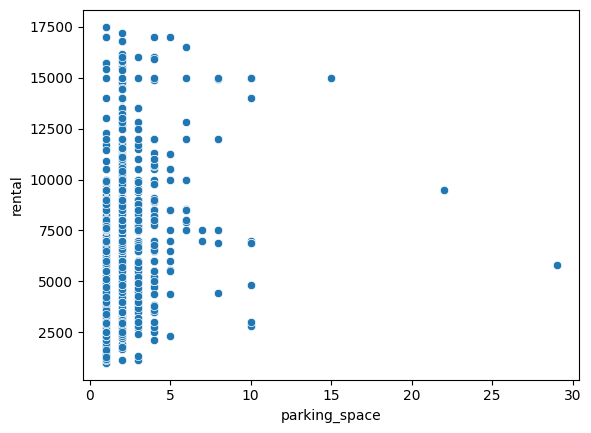

In [120]:
## Vamos ver o preço o crescimento do preço com relação as vagas de garagem
sns.scatterplot(x=df_processed['parking_space'], y=df_processed['rental'])

<Axes: >

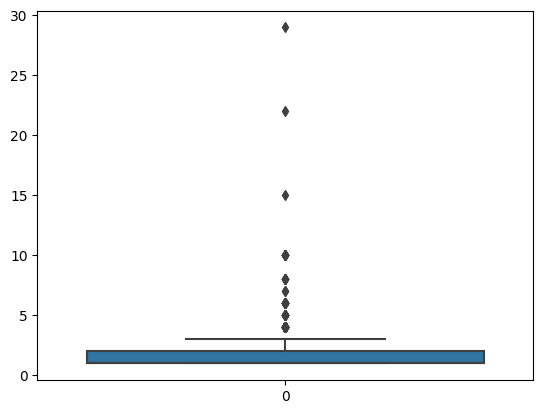

In [130]:
# Da mesma forma para o parking space, manteremos os dados
sns.boxplot(df_processed['parking_space'])

## Dividindo os dados em treino e teste

In [182]:
from sklearn.preprocessing import MinMaxScaler
## from sklearn.preprocessing import OneHotEncoder ## Podemos aplicar essa modelo no district

In [170]:
mms = MinMaxScaler()
ohe = OneHotEncoder()

In [171]:
columns_keys = df_processed.drop(columns=['rental', 'district']).keys()

In [172]:
X = df_processed.drop(columns=['rental', 'district'])
y = df_processed['rental']
X = pd.DataFrame(mms.fit_transform(X, y), columns=columns_keys)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [174]:
X_train.to_csv('X_train', index=False)
X_test.to_csv('X_test', index=False)
y_train.to_csv('y_train', index=False)
y_test.to_csv('y_test', index=False)

In [175]:
X_train = pd.read_csv('X_train')
X_test = pd.read_csv('X_test')
y_train = pd.read_csv('y_train')
y_test = pd.read_csv('y_test')

## Criando modelo

#### Importando bibliotecas

In [176]:
from sklearn.ensemble import RandomForestRegressor

In [177]:
tree = RandomForestRegressor(random_state=29)

#### Treinando modelo

In [178]:
tree.fit(X_train, y_train['rental'])

RandomForestRegressor(random_state=29)

#### Avaliando modelo

In [179]:
ypred = pd.DataFrame(tree.predict(X_test))

In [180]:
k = X_test.shape[1]
n = len(X_test)

MSE = mean_squared_error(y_test, ypred)
MAE = mean_absolute_error(y_test, ypred)
R2_Score = r2_score(y_test, ypred)
adj_r2 = 1 - (((1 - R2_Score) * (n - 1)) / (n - k - 1))

print(f'''
MSE:    {MSE}
MAE:    {MAE}
R2:     {R2_Score}
ADJ_R2: {adj_r2}
''')


MSE:    2811703.2103887233
MAE:    1126.6945458222456
R2:     0.6908825673454614
ADJ_R2: 0.6875705948527342



Text(0.5, 1.0, 'Real x Previsto')

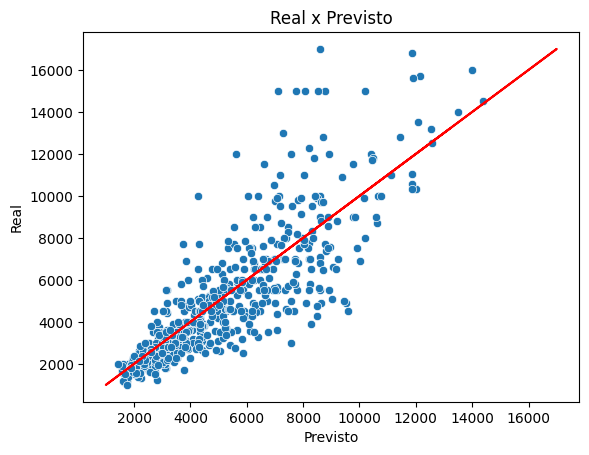

In [181]:
sns.scatterplot(x=ypred.iloc[:,0], y=y_test.iloc[:,0])
plt.plot(y_test, y_test, color='red')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Real x Previsto')

## Conclusão

No geral o modelo desempenhou bem o papel para prever os alugueis, mas com dificuldade para prever alugueis com valores um pouco mais altos:

    MSE:    3231796.8148358
    MAE:    1165.2483077906807
    R2:     0.6831207125583769
    ADJ_R2: 0.6797255773357881

As variáveis conseguem explicar em 68% a variação do preço, não existe nem uma variável dispensável visto que a r2 ajustada se equipara ao r2, então talvez coletar mais alguns atributos relevantes para melhorar o modelo seria uma solução.